In [17]:
from os import listdir
from os.path import isfile, join

mypath = "./datasets/images/"

file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]

print(str(len(file_names)) + ' images loaded')

18752 images loaded


In [18]:
import cv2
import numpy as np
import sys
import os
import shutil

# Extract 1000 for our training data and 500 for our validation set\n",
# Takes about ~20 seconds to run\n",
dog_count = 0
cat_count = 0
training_size = 1000
test_size = 500
training_images = []
training_labels = []
test_images = []
test_labels = []
size = 150
dog_dir_train = "./datasets/catsvsdogs/train/dogs/"
cat_dir_train = "./datasets/catsvsdogs/train/cats/"
dog_dir_val = "./datasets/catsvsdogs/validation/dogs/"
cat_dir_val = "./datasets/catsvsdogs/validation/cats/"

def make_dir(directory):
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)

make_dir(dog_dir_train)
make_dir(cat_dir_train)
make_dir(dog_dir_val)
make_dir(cat_dir_val)

def getZeros(number):
    if(number > 10 and number < 100):
        return "0"
    if(number < 10):
        return "00"
    else:
        return ""
for i, file in enumerate(file_names):
    if file_names[i][0] == "d":
        dog_count += 1
        image = cv2.imread(mypath+file)
        image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            zeros = getZeros(dog_count)
            cv2.imwrite(dog_dir_train + "dog" + str(zeros) + str(dog_count) + ".jpg", image)
        if dog_count > training_size and dog_count <= training_size+test_size:
            test_images.append(image)
            test_labels.append(1)
            zeros = getZeros(dog_count-1000)
            cv2.imwrite(dog_dir_val + "dog" + str(zeros) + str(dog_count-1000) + ".jpg", image)
    if file_names[i][0] == "c":
        cat_count += 1
        image = cv2.imread(mypath+file)
        image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            zeros = getZeros(cat_count)
            cv2.imwrite(cat_dir_train + "cat" + str(zeros) + str(cat_count) + ".jpg", image)
        if cat_count > training_size and cat_count <= training_size+test_size:
            test_images.append(image)
            test_labels.append(0)
            zeros = getZeros(cat_count-1000)
            cv2.imwrite(cat_dir_val + "cat" + str(zeros) + str(cat_count-1000) + ".jpg", image)
    if dog_count == training_size+test_size and cat_count == training_size+test_size:
        break

print("Training and Test Data Extraction Complete")

Training and Test Data Extraction Complete


In [19]:
# Using numpy's savez function to store our loaded data as NPZ files
np.savez('cats_vs_dogs_training_data.npz', np.array(training_images))
np.savez('cats_vs_dogs_training_labels.npz', np.array(training_labels))
np.savez('cats_vs_dogs_test_data.npz', np.array(test_images))
np.savez('cats_vs_dogs_test_labels.npz', np.array(test_labels))

In [20]:
# Loader Function\n",
import numpy as np

def load_data_training_and_test(datasetname):
    npzfile = np.load(datasetname + "_training_data.npz")
    train = npzfile['arr_0']

    npzfile = np.load(datasetname + "_training_labels.npz")
    train_labels = npzfile['arr_0']
    npzfile = np.load(datasetname + "_test_data.npz")
    test = npzfile['arr_0']

    npzfile = np.load(datasetname + "_test_labels.npz")
    test_labels = npzfile['arr_0']
    return (train, train_labels), (test, test_labels)

In [21]:
for i in range(1,11):
    random = np.random.randint(0, len(training_images))
    cv2.imshow("image_"+str(i), training_images[random])
    if training_labels[random] == 0:
        print(str(i) + " - Cat")
    else:
        print(str(i)+ " - Dog")
    cv2.waitKey(0)

cv2.destroyAllWindows()

1 - Cat
2 - Cat
3 - Cat
4 - Dog
5 - Dog
6 - Dog
7 - Dog
8 - Dog
9 - Dog
10 - Dog


In [22]:
(x_train, y_train), (x_test, y_test) = load_data_training_and_test("cats_vs_dogs")

# Reshaping our label data from (2000,) to (2000,1) and test data from (1000,) to (1000,1)\n",
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type\n",
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)\n",
x_train /= 255
x_test /= 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2000, 150, 150, 3)
(2000, 1)
(1000, 150, 150, 3)
(1000, 1)


In [23]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 16
epochs = 25

img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]
input_shape = (img_rows, img_cols, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [24]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

model.save("Trained Models/cats_vs_dogs_V1.h5")

# Evaluate the performance of our trained model\n",
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 2000 samples, validate on 1000 samples
Epoch 1/25
2000/2000 [==============================] - 9s 5ms/step - loss: 0.7115 - acc: 0.4935 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6843 - acc: 0.5680 - val_loss: 0.6773 - val_acc: 0.5570
Epoch 3/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.6491 - acc: 0.6375 - val_loss: 0.6434 - val_acc: 0.6520
Epoch 4/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.5919 - acc: 0.6925 - val_loss: 0.6351 - val_acc: 0.6800
Epoch 5/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.5399 - acc: 0.7385 - val_loss: 0.6393 - val_acc: 0.6760
Epoch 6/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.4909 - acc: 0.7640 - val_loss: 0.6315 - val_acc: 0.6770
Epoch 7/25
2000/2000 [==============================] - 7s 4ms/step - loss: 0.4444 - acc: 0.8040 - val_loss: 0.6453 - val_acc: 0.6800
Epoch 8/25
200

In [25]:
import cv2
import numpy as np
from keras.models import load_model

classifier = load_model('Trained Models/cats_vs_dogs_V1.h5')

def draw_test(name, pred, input_im):
    BLACK = [0,0,0]
    if pred == "[0]":
        pred = "cat"
    if pred == "[1]":
        pred = "dog"
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0] ,cv2.BORDER_CONSTANT,value=BLACK)
    #expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)\n",
    cv2.putText(expanded_image, str(pred), (252, 70) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,0), 2)
    cv2.imshow(name, expanded_image)

for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]

    imageL = cv2.resize(input_im, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    cv2.imshow("Test Image", imageL)
    input_im = input_im.reshape(1,150,150,3) 
    ## Get Prediction\n",
    res = str(classifier.predict_classes(input_im, 1, verbose = 0)[0])

    draw_test("Prediction", res, imageL) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [26]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import scipy
import pylab as pl
import matplotlib.cm as cm
%matplotlib inline

input_shape = (150, 150, 3)
img_width = 150
img_height = 150
nb_train_samples = 2000
nb_validation_samples = 1000
batch_size = 16
epochs = 25
train_data_dir = './datasets/catsvsdogs/train'
validation_data_dir = './datasets/catsvsdogs/validation'

# Creating our data generator for our test data\n",
validation_datagen = ImageDataGenerator(
    # used to rescale the pixel values from [0, 255] to [0, 1] interval\n",
    rescale = 1./255)

# Creating our data generator for our training data\n",
train_datagen = ImageDataGenerator(
      rescale = 1./255,              # normalize pixel values to [0,1]\n",
      rotation_range = 30,           # randomly applies rotations\n",
      width_shift_range = 0.3,       # randomly applies width shifting\n",
      height_shift_range = 0.3,      # randomly applies height shifting\n",
      horizontal_flip = True,        # randonly flips the image\n",
      fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above\n",

# Specify criteria about our training data, such as the directory, image size, batch size and type \n",
# automagically retrieve images and their classes for train and validation sets\n",
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = False)    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
125/125 [==============================] - 20s 157ms/step - loss: 0.7309 - acc: 0.5220 - val_loss: 0.7050 - val_acc: 0.5071
Epoch 2/25
125/125 [==============================] - 16s 127ms/step - loss: 0.6860 - acc: 0.5470 - val_loss: 0.8108 - val_acc: 0.6067
Epoch 3/25
125/125 [==============================] - 20s 156ms/step - loss: 0.6842 - acc: 0.5705 - val_loss: 0.6887 - val_acc: 0.6524
Epoch 4/25
125/125 [==============================] - 16s 125ms/step - loss: 0.6873 - acc: 0.5770 - val_loss: 0.6654 - val_acc: 0.6016
Epoch 5/25
125/125 [==============================] - 15s 123ms/step - loss: 0.6856 - acc: 0.5715 - val_loss: 0.6474 - val_acc: 0.6697
Epoch 6/25
125/125 [==============================] - 35s 283ms/step - loss: 0.6753 - acc: 0.6015 - val_loss: 0.6806 - val_acc: 0.6707
Epoch 7/25
125/125 [==============================] - 25s 200ms/step - loss: 0.6672 - acc: 0.6225 - val_loss: 0.6333 - val_acc: 0.6931
Epoch 8/25
125/125 [==============================] - 2

In [28]:
# Creating out model\n",
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)        18496     
__________

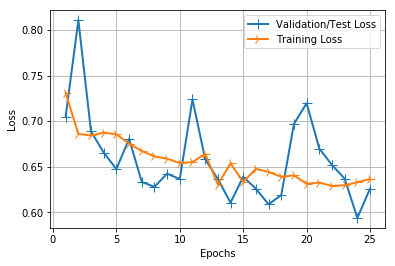

In [29]:
# Plotting our loss charts\n",
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

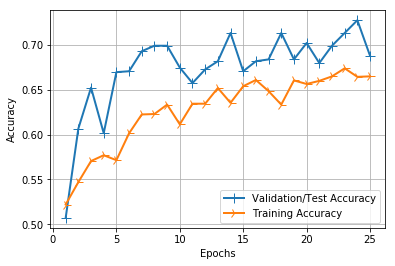

In [30]:
# Plotting our accuracy charts\n",
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()